# YOLO-OBB Boat Detection — Model Evaluation


## Notebook Structure

| Section | Description |
|---------|-------------|
| 1. Setup | Imports, paths, constants |
| 2. Model Loading | Load best YOLO-OBB checkpoint |
| 3. Confidence Threshold Search | Grid search over confidence values to maximise mAP |
| 4. Test-Set Evaluation | Final metrics at optimal threshold |
| 5. Per-Class Performance Table | Precision, Recall, F1, mAP per class |
| 6. Confusion Matrix | Normalised inter-class confusion |
| 7. Dataset Statistics | Class distribution across splits |
| 8. Object Size Analysis | Geometric statistics per class (OBB) |
| 9. Size × Performance Correlation | Spearman ρ between size/count and mAP |

## 1. Setup

All imports and global constants are centralised here. Change `MODEL_PATH`, `DATA_PATH`, or `PROCESSED_DIR` to adapt to your environment.

In [1]:
# ── Standard library ──────────────────────────────────────────────────────────
import logging
import os
from collections import Counter, defaultdict
from pathlib import Path

# ── Third-party ───────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
from ultralytics import YOLO

# ── Silence Ultralytics progress bars in the notebook ─────────────────────────
logging.getLogger("ultralytics").setLevel(logging.ERROR)

# ── Matplotlib style ──────────────────────────────────────────────────────────
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ── Paths ─────────────────────────────────────────────────────────────────────
MODEL_PATH   = Path("runs/obb/runs/optuna/boat_obb_study/final_retrain/weights/best.pt")
DATA_PATH    = Path("data/dataset.yaml")
PROCESSED_DIR = Path("data/processed")

# ── Constants ─────────────────────────────────────────────────────────────────
IMG_SIZE   = 1536
TILE_SIZE  = 1024
SPLITS     = ["train", "val", "test"]
LABELS_ROOT = PROCESSED_DIR / "labels"

print(f"Model path  : {MODEL_PATH}")
print(f"Data config : {DATA_PATH}")
print(f"Tile size   : {TILE_SIZE} px | Image size : {IMG_SIZE} px")

Model path  : runs/obb/runs/optuna/boat_obb_study/final_retrain/weights/best.pt
Data config : data/dataset.yaml
Tile size   : 1024 px | Image size : 1536 px


## 2. Model Loading

We load the final retrained YOLO-OBB checkpoint produced by Optuna after selecting the best hyperparameter trial.

In [2]:
model = YOLO(MODEL_PATH)
CLASS_NAMES = model.names   # dict {id: name}

print("Classes:")
for cid, name in CLASS_NAMES.items():
    print(f"  [{cid}] {name}")

Classes:
  [0] Pirogue
  [1] Double_hulled_Pirogue
  [2] Small_Motorboat
  [3] Medium_Motorboat
  [4] Large_Motorboat
  [5] Sailing_Boat


## 3. Confidence Threshold Search

We sweep 25 confidence values in [0.01, 0.90] and record global and per-class mAP50-95 on the **test split**.  
The optimal threshold is selected by maximising mean mAP50-95.

> **Note:** This cell is computationally expensive (~25 full inference passes). Results are cached in `df_global` and `df_class` for subsequent cells.

In [ ]:
CONF_VALUES = np.linspace(0.01, 0.90, 25)
VAL_KWARGS = dict(
    data=str(DATA_PATH), split="test", imgsz=TILE_SIZE,
    iou=0.3, plots=False, verbose=False,
    project="val", name="sweep", exist_ok=True,  
)

global_rows    = []
per_class_rows = []

for conf in CONF_VALUES:
    m = model.val(conf=float(conf), **VAL_KWARGS)

    global_rows.append({
        "conf":      conf,
        "mAP50-95":  float(m.box.map),
        "Precision": float(m.box.mp),
        "Recall":    float(m.box.mr),
    })

    ap = m.box.ap
    if ap.ndim == 2:
        ap = ap.mean(axis=1)   # mean over IoU thresholds

    for cid, name in CLASS_NAMES.items():
        per_class_rows.append({
            "conf":      conf,
            "Class":     name,
            "mAP50-95":  float(ap[cid]),
            "Precision": float(m.box.p[cid]),
            "Recall":    float(m.box.r[cid]),
        })

df_global = pd.DataFrame(global_rows)
df_class  = pd.DataFrame(per_class_rows)

# ── Best threshold dict  {class_name: conf, ..., "global": conf} ──────────────
BEST_CONF: dict[str, float] = {}

# Per-class: conf that maximises mAP50-95 for each class
for cls_name, grp in df_class.groupby("Class"):
    BEST_CONF[cls_name] = float(grp.loc[grp["mAP50-95"].idxmax(), "conf"])

# Global: conf that maximises mean mAP50-95 across all classes
best_global_row = df_global.loc[df_global["mAP50-95"].idxmax()]
BEST_CONF["global"] = float(best_global_row["conf"])

# ── Best per-class summary table ───────────────────────────────────────────────
best_per_class = (
    df_class.sort_values("mAP50-95", ascending=False)
            .groupby("Class", as_index=False)
            .first()
            .sort_values("Class")
)

# ── Print summary ──────────────────────────────────────────────────────────────
print(f"BEST_CONF dict:")
for key, val in BEST_CONF.items():
    marker = " ← global" if key == "global" else ""
    print(f"  {key:<25} {val:.4f}{marker}")

print()
print(f"Global best → conf={BEST_CONF['global']:.4f} | "
      f"mAP50-95={best_global_row['mAP50-95']:.4f} | "
      f"P={best_global_row['Precision']:.4f} | "
      f"R={best_global_row['Recall']:.4f}")
print()
print("Best per-class confidence (mAP50-95 optimised):")
display(best_per_class[["Class", "conf", "mAP50-95", "Precision", "Recall"]].round(4))


BEST_CONF dict:
  Double_hulled_Pirogue     0.1213
  Large_Motorboat           0.0100
  Medium_Motorboat          0.1213
  Pirogue                   0.4179
  Sailing_Boat              0.5292
  Small_Motorboat           0.0842
  global                    0.1213 ← global

Global best → conf=0.1213 | mAP50-95=0.4606 | P=0.5810 | R=0.6952

Best per-class confidence (mAP50-95 optimised):


,Class,conf,mAP50-95,Precision,Recall
0,Double_hulled_Pirogue,0.1212,0.6705,0.7665,0.8244
1,Large_Motorboat,0.0100,0.3980,0.4337,1.0000
2,Medium_Motorboat,0.1212,0.1946,0.3655,0.2437
3,Pirogue,0.4179,0.4413,0.8923,0.4677
4,Sailing_Boat,0.5292,0.5741,1.0000,0.3333
5,Small_Motorboat,0.0842,0.5911,0.5920,0.9091


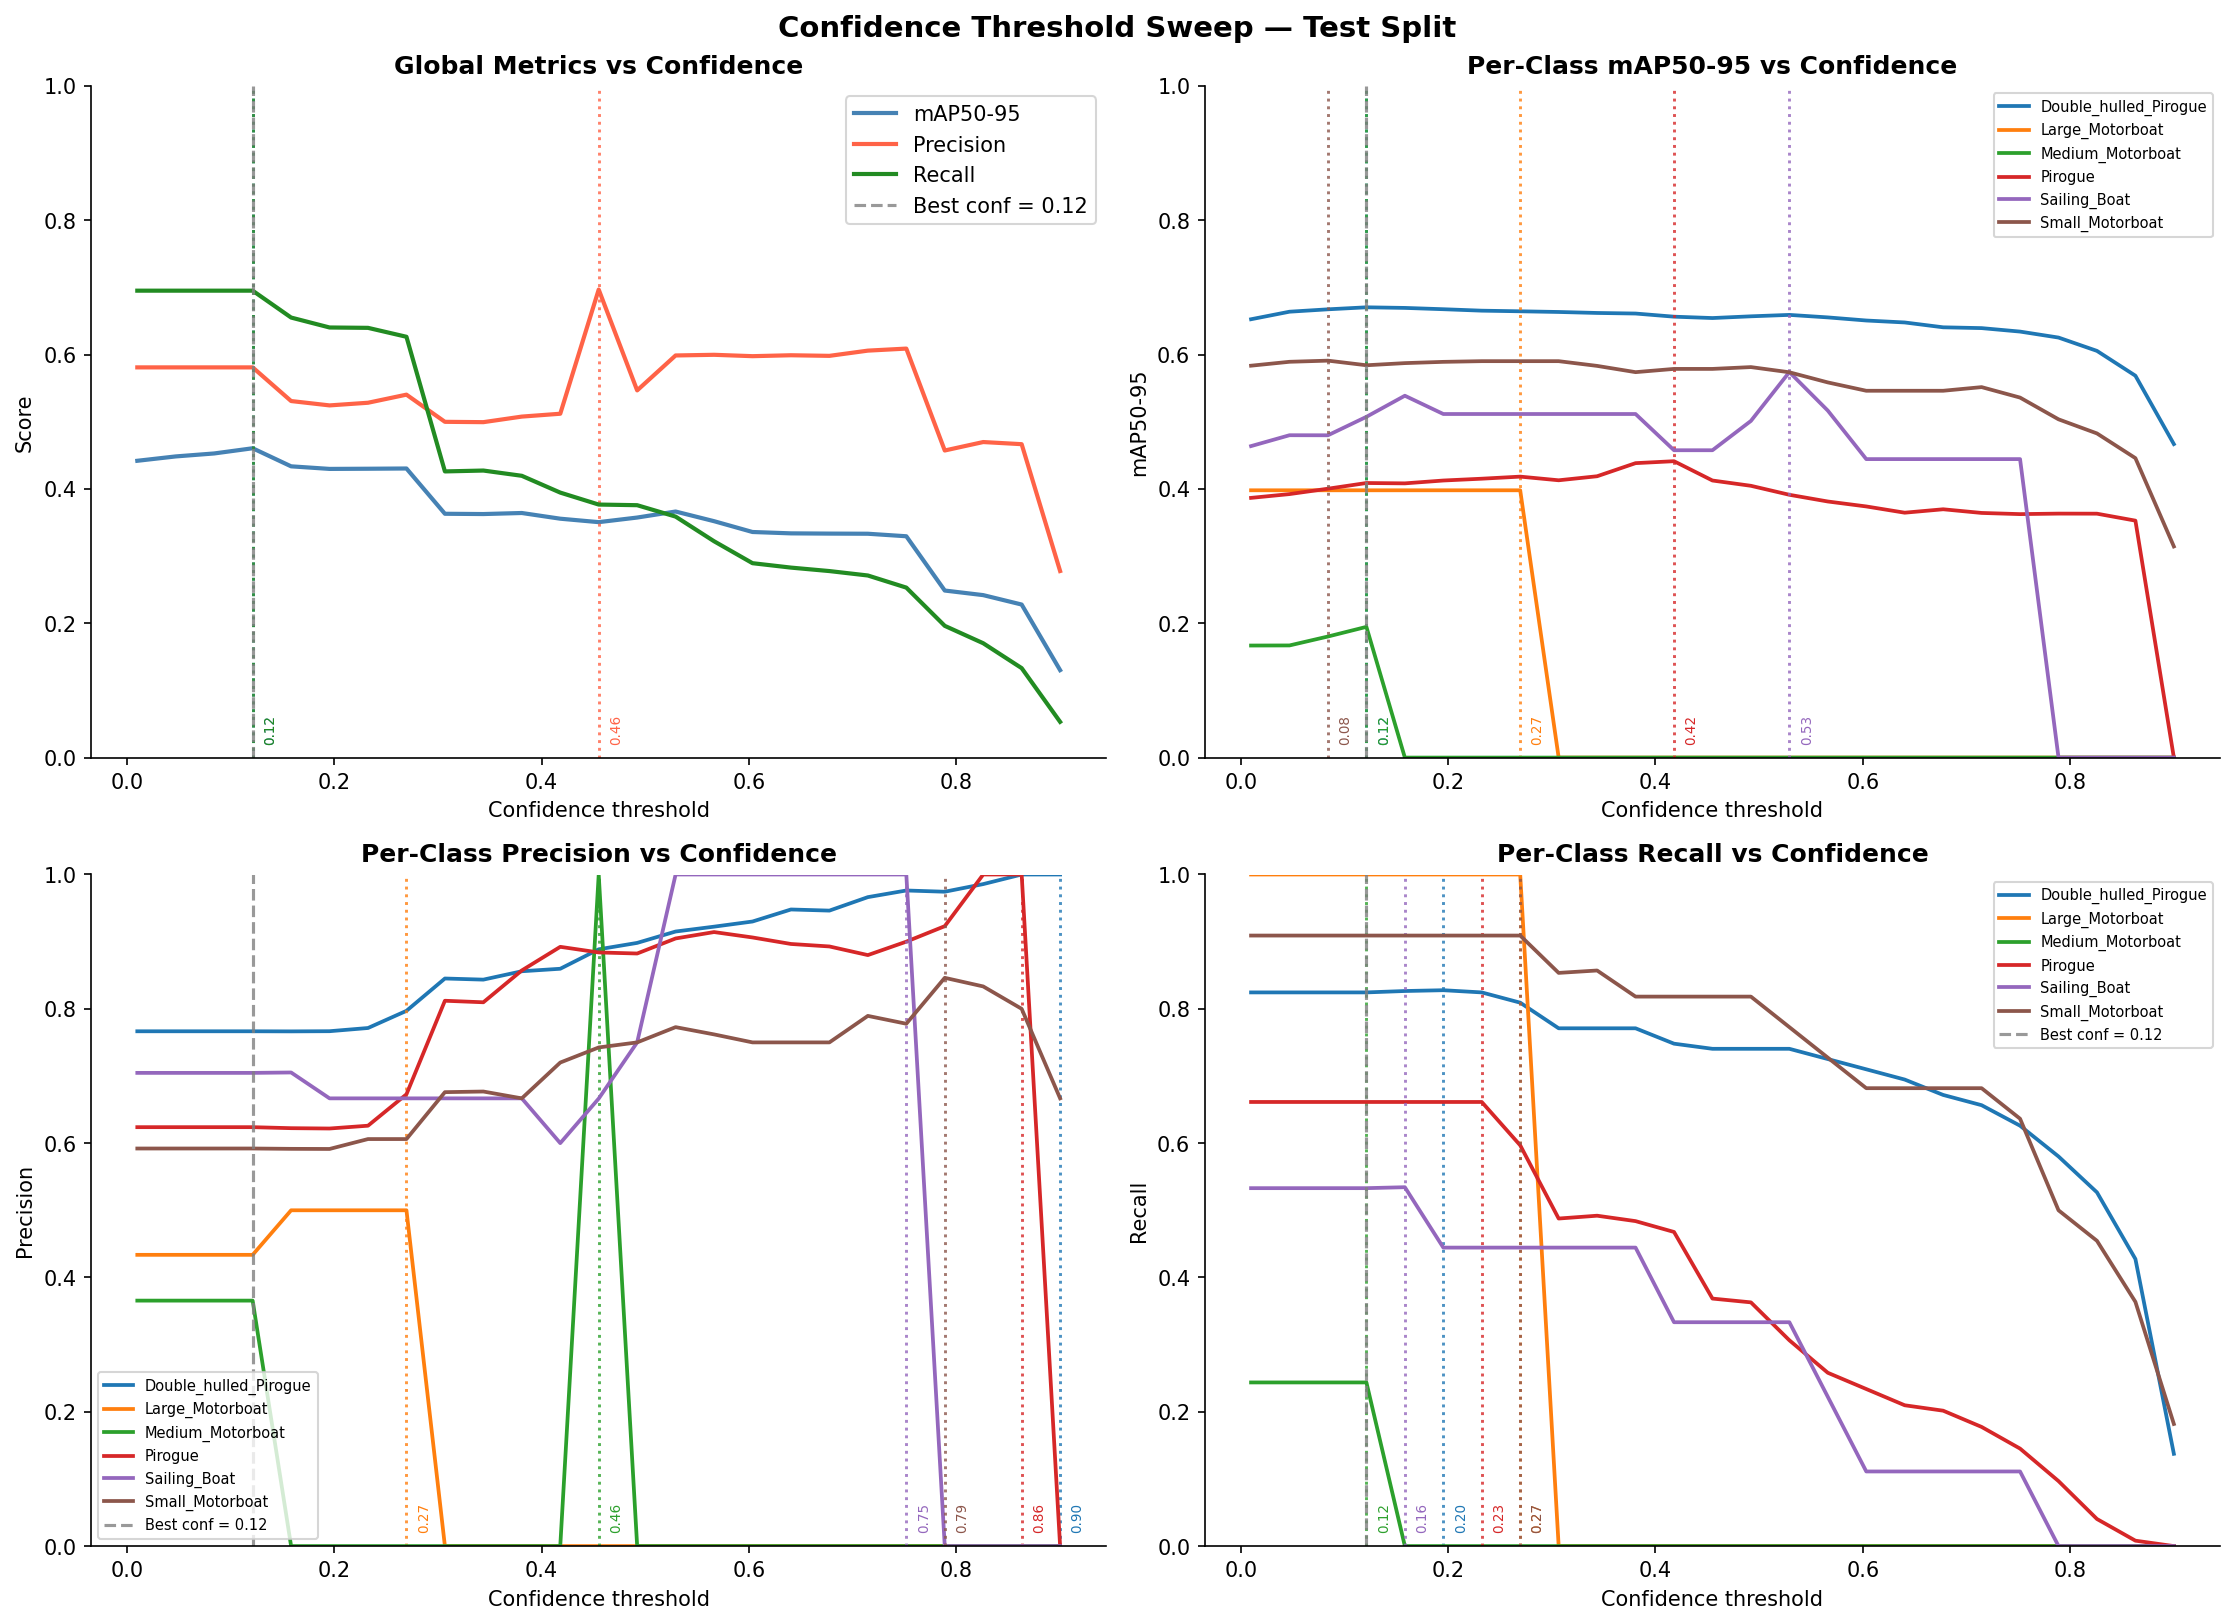

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))
axes = axes.flatten()

PALETTE  = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cls_list = sorted(df_class["Class"].unique())


def mark_max(ax, x, y, color):
    """Vertical dotted line at the max of y.
    If multiple points share the max (flat top), use the last one."""
    y_max  = y.max()
    # among all indices at the maximum, pick the last
    idx    = y[y == y_max].index[-1]
    x_max  = x.loc[idx]
    ax.axvline(x_max, linestyle=":", color=color, alpha=0.8, lw=1.4)
    ax.text(x_max + 0.01, 0.02, f"{x_max:.2f}",
            color=color, fontsize=6.5, va="bottom", rotation=90)


# ── (0) Global metrics vs confidence ──────────────────────────────────────────
ax = axes[0]
for metric, color in [("mAP50-95", "steelblue"), ("Precision", "tomato"), ("Recall", "forestgreen")]:
    ax.plot(df_global["conf"], df_global[metric], label=metric, color=color, lw=2)
    mark_max(ax, df_global["conf"], df_global[metric], color)
ax.axvline(BEST_CONF["global"], linestyle="--", color="gray", alpha=0.8,
           label=f"Best conf = {BEST_CONF['global']:.2f}")
ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Score")
ax.set_title("Global Metrics vs Confidence", fontweight="bold")
ax.legend()
ax.set_ylim(0, 1)

# ── (1) Per-class mAP50-95 vs confidence ──────────────────────────────────────
ax = axes[1]
for idx, cls_name in enumerate(cls_list):
    grp   = df_class[df_class["Class"] == cls_name].reset_index(drop=True)
    color = PALETTE[idx % len(PALETTE)]
    ax.plot(grp["conf"], grp["mAP50-95"], label=cls_name, color=color, lw=1.8)
    mark_max(ax, grp["conf"], grp["mAP50-95"], color)
ax.axvline(BEST_CONF["global"], linestyle="--", color="gray", alpha=0.8)
ax.set_xlabel("Confidence threshold")
ax.set_ylabel("mAP50-95")
ax.set_title("Per-Class mAP50-95 vs Confidence", fontweight="bold")
ax.legend(fontsize=7)
ax.set_ylim(0, 1)

# ── (2) Per-class Precision vs confidence ─────────────────────────────────────
ax = axes[2]
for idx, cls_name in enumerate(cls_list):
    grp   = df_class[df_class["Class"] == cls_name].reset_index(drop=True)
    color = PALETTE[idx % len(PALETTE)]
    ax.plot(grp["conf"], grp["Precision"], label=cls_name, color=color, lw=1.8)
    mark_max(ax, grp["conf"], grp["Precision"], color)
ax.axvline(BEST_CONF["global"], linestyle="--", color="gray", alpha=0.8,
           label=f"Best conf = {BEST_CONF['global']:.2f}")
ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Precision")
ax.set_title("Per-Class Precision vs Confidence", fontweight="bold")
ax.legend(fontsize=7)
ax.set_ylim(0, 1)

# ── (3) Per-class Recall vs confidence ────────────────────────────────────────
ax = axes[3]
for idx, cls_name in enumerate(cls_list):
    grp   = df_class[df_class["Class"] == cls_name].reset_index(drop=True)
    color = PALETTE[idx % len(PALETTE)]
    ax.plot(grp["conf"], grp["Recall"], label=cls_name, color=color, lw=1.8)
    mark_max(ax, grp["conf"], grp["Recall"], color)
ax.axvline(BEST_CONF["global"], linestyle="--", color="gray", alpha=0.8,
           label=f"Best conf = {BEST_CONF['global']:.2f}")
ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Recall")
ax.set_title("Per-Class Recall vs Confidence", fontweight="bold")
ax.legend(fontsize=7)
ax.set_ylim(0, 1)

fig.suptitle("Confidence Threshold Sweep — Test Split", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## 4. Test-Set Evaluation

Single full evaluation at the optimal confidence threshold (`BEST_CONF`).  
This call also generates the PR-curve and confusion-matrix plots used by Ultralytics.

In [5]:
metrics = model.val(
    data=str(DATA_PATH),
    split="test",
    imgsz=IMG_SIZE,
    conf=0.23,
    iou=0.3,
    save_json=True,
    plots=True,
    verbose=False,
)

print(f"mAP50    : {metrics.box.map50:.4f}")
print(f"mAP50-95 : {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall   : {metrics.box.mr:.4f}")

mAP50    : 0.6352
mAP50-95 : 0.4876
Precision: 0.7005
Recall   : 0.6289


## 5. Per-Class Performance Table

We aggregate Precision, Recall, F1, mAP50 and mAP50-95 per class, alongside **Support** (number of ground-truth instances in the test set).  
A global (macro-averaged) row is appended at the bottom.

In [6]:
# ── Support (GT instances per class in test split) ────────────────────────────
class_counter: Counter = Counter()
for txt in (LABELS_ROOT / "test").glob("*.txt"):
    for line in txt.read_text().splitlines():
        line = line.strip()
        if line:
            class_counter[int(line.split()[0])] += 1

support = [class_counter.get(i, 0) for i in range(len(CLASS_NAMES))]

# ── Per-class metrics ─────────────────────────────────────────────────────────
p_per_class   = metrics.box.p
r_per_class   = metrics.box.r
map_per_class = metrics.box.maps
ap50_per_class = metrics.box.ap50 if hasattr(metrics.box, "ap50") else [np.nan] * len(CLASS_NAMES)

rows = []
for cid, name in CLASS_NAMES.items():
    p = float(p_per_class[cid])
    r = float(r_per_class[cid])
    f1 = 2 * p * r / (p + r + 1e-9)
    rows.append({
        "Class": name,
        "Support": support[cid],
        "Precision": p,
        "Recall": r,
        "F1-score": f1,
        "mAP50": float(ap50_per_class[cid]),
        "mAP50-95": float(map_per_class[cid]),
    })

# ── Global row ────────────────────────────────────────────────────────────────
p_g = float(metrics.box.mp)
r_g = float(metrics.box.mr)
rows.append({
    "Class": "**Global**",
    "Support": sum(support),
    "Precision": p_g,
    "Recall": r_g,
    "F1-score": 2 * p_g * r_g / (p_g + r_g + 1e-9),
    "mAP50": float(metrics.box.map50),
    "mAP50-95": float(metrics.box.map),
})

df_perf = pd.DataFrame(rows)

# Sort classes by mAP50-95 descending, keep Global last
df_perf = pd.concat([
    df_perf[df_perf["Class"] != "**Global**"].sort_values("mAP50-95", ascending=False),
    df_perf[df_perf["Class"] == "**Global**"],
]).reset_index(drop=True)

display(df_perf.round(4))

,Class,Support,Precision,Recall,F1-score,mAP50,mAP50-95
0,Double_hulled_Pirogue,138,0.8385,0.8321,0.8352,0.8844,0.6811
1,Small_Motorboat,27,0.6800,0.7727,0.7234,0.7670,0.5977
2,Medium_Motorboat,7,1.0000,0.3333,0.5000,0.6667,0.5333
3,Pirogue,124,0.6847,0.6129,0.6468,0.6901,0.4405
4,Large_Motorboat,3,0.5000,1.0000,0.6667,0.4975,0.3980
5,Sailing_Boat,9,0.5000,0.2222,0.3077,0.3056,0.2750
6,**Global**,308,0.7005,0.6289,0.6628,0.6352,0.4876


## 6. Confusion Matrix

Row-normalised confusion matrix (each row sums to 1).  
Background detections are excluded to focus on inter-class confusion.

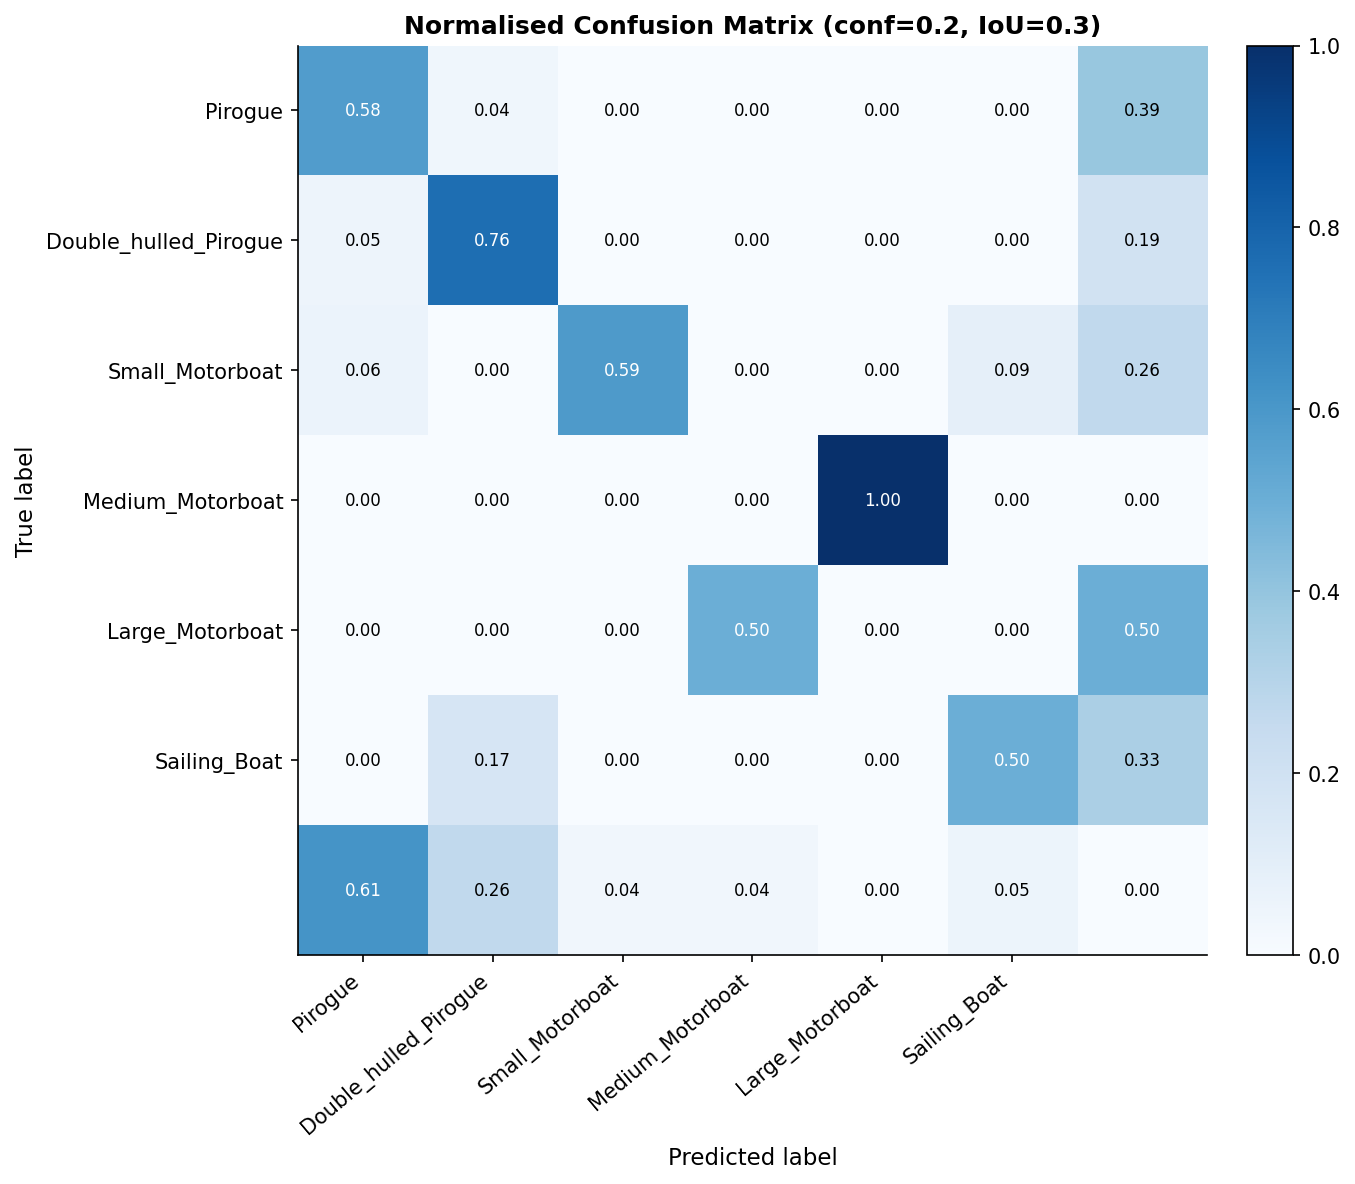

In [7]:
# Re-evaluate with conf=0.2 to maximise recall for the confusion matrix
metrics_cm = model.val(
    data=str(DATA_PATH),
    split="test",
    imgsz=TILE_SIZE,
    conf=0.2,
    iou=0.3,
    plots=True,
    save_json=False,
    verbose=False,
)

cm_raw      = metrics_cm.confusion_matrix.matrix   # shape (nc+1, nc+1)
cm_norm     = cm_raw  / (cm_raw .sum(axis=1, keepdims=True) + 1e-9)
class_labels = list(CLASS_NAMES.values())

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.imshow(cm_norm, vmin=0, vmax=1, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ticks = np.arange(len(class_labels))
ax.set_xticks(ticks); ax.set_xticklabels(class_labels, rotation=40, ha="right")
ax.set_yticks(ticks); ax.set_yticklabels(class_labels)

thresh = cm_norm.max() / 2.0
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        v = cm_norm[i, j]
        if not np.isnan(v):
            color = "white" if v > thresh else "black"
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    fontsize=8, color=color)


ax.set_ylabel("True label", fontsize=11)
ax.set_xlabel("Predicted label", fontsize=11)
ax.set_title("Normalised Confusion Matrix (conf=0.2, IoU=0.3)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

In [8]:
print("Confusion matrix raw:")
print(metrics_cm.confusion_matrix.matrix)
print("Sum of matrix:", metrics_cm.confusion_matrix.matrix.sum())


print(metrics_cm.box.mp)
print(metrics_cm.box.mr)

Confusion matrix raw:
[[         80           5           0           0           0           0          54]
 [          7         110           0           0           0           0          28]
 [          2           0          20           0           0           3           9]
 [          0           0           0           0           1           0           0]
 [          0           0           0           1           0           0           1]
 [          0           1           0           0           0           3           2]
 [         35          15           2           2           0           3           0]]
Sum of matrix: 384.0
0.5244030047937726
0.6404205863073852


## 7. Dataset Statistics

Class distribution across train / val / test splits.

Object counts per class and split:


,Class,Train,Val,Test,Total
0,Pirogue,1613,138,124,1875
1,Double_hulled_Pirogue,1297,131,138,1566
2,Small_Motorboat,592,87,27,706
3,Medium_Motorboat,243,14,7,264
4,Large_Motorboat,51,4,3,58
5,Sailing_Boat,227,8,9,244


train   4023 objects   586/8218 annotated tiles
val      382 objects    53/58 annotated tiles
test     308 objects    53/58 annotated tiles


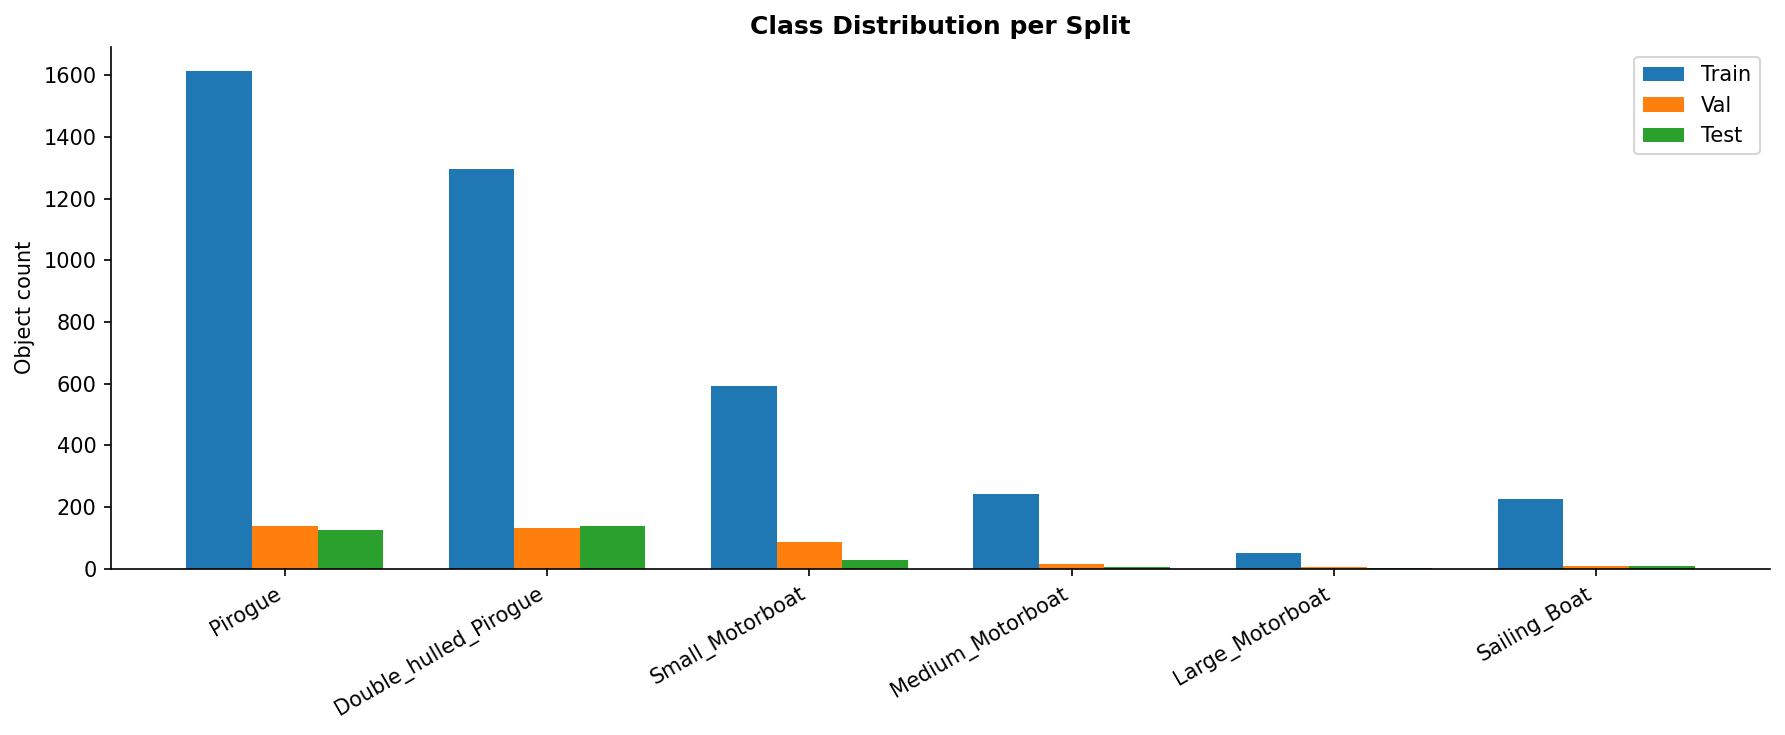

In [9]:
def count_split(labels_dir: Path) -> tuple[dict, int, int]:
    """Count per-class instances and annotated tiles in a label directory."""
    counts: dict[int, int] = defaultdict(int)
    annotated = 0
    txt_files = list(labels_dir.glob("*.txt"))
    for txt in txt_files:
        lines = [l.strip() for l in txt.read_text().splitlines() if l.strip()]
        if lines:
            annotated += 1
        for line in lines:
            counts[int(line.split()[0])] += 1
    return dict(counts), len(txt_files), annotated


split_data = {s: count_split(LABELS_ROOT / s) for s in SPLITS}

# ── Summary table ─────────────────────────────────────────────────────────────
all_cids = sorted({cid for s in split_data.values() for cid in s[0]})
summary_rows = []
for cid in all_cids:
    row = {"Class": CLASS_NAMES[cid]}
    for split in SPLITS:
        row[split.capitalize()] = split_data[split][0].get(cid, 0)
    row["Total"] = sum(split_data[s][0].get(cid, 0) for s in SPLITS)
    summary_rows.append(row)

df_dist = pd.DataFrame(summary_rows)
print("Object counts per class and split:")
display(df_dist)

for split in SPLITS:
    counts, n_tiles, n_ann = split_data[split]
    total = sum(counts.values())
    print(f"{split:5s}  {total:>5d} objects  {n_ann:>4d}/{n_tiles} annotated tiles")

# ── Bar chart ─────────────────────────────────────────────────────────────────
x      = np.arange(len(all_cids))
width  = 0.25
labels = [CLASS_NAMES[c] for c in all_cids]

fig, ax = plt.subplots(figsize=(12, 5))
for i, split in enumerate(SPLITS):
    values = [split_data[split][0].get(c, 0) for c in all_cids]
    ax.bar(x + i * width, values, width, label=split.capitalize())

ax.set_xticks(x + width)
ax.set_xticklabels(labels, rotation=30, ha="right")
ax.set_ylabel("Object count")
ax.set_title("Class Distribution per Split", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

## 8. Object Size Analysis (OBB)

For each annotated OBB polygon we compute:
- **Long side** — major axis length (px)
- **Short side** — minor axis length (px)
- **Area** — polygon area via the shoelace formula (px²)
- **Aspect ratio** — mean(long / short)

Coordinates are normalised in YOLO format; we rescale by `TILE_SIZE` to obtain pixel values.

In [10]:
def shoelace_area(pts: list[tuple[float, float]]) -> float:
    """Polygon area using the shoelace formula."""
    x = np.array([p[0] for p in pts])
    y = np.array([p[1] for p in pts])
    return 0.5 * abs(float(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1))))


def quad_sides(pts: list[tuple[float, float]]) -> list[float]:
    """Return the four side lengths of a quadrilateral."""
    return [np.hypot(pts[(i+1)%4][0] - pts[i][0],
                     pts[(i+1)%4][1] - pts[i][1])
            for i in range(4)]


class_stats: dict = defaultdict(lambda: {"long": [], "short": [], "area": []})

for split in SPLITS:
    for txt in (LABELS_ROOT / split).glob("*.txt"):
        for line in txt.read_text().splitlines():
            line = line.strip()
            if not line:
                continue
            parts    = line.split()
            cid      = int(parts[0])
            coords   = list(map(float, parts[1:9]))
            pts_norm = [(coords[2*k], coords[2*k+1]) for k in range(4)]
            pts_px   = [(x * TILE_SIZE, y * TILE_SIZE) for x, y in pts_norm]
            sides    = quad_sides(pts_px)
            class_stats[cid]["long"].append(max(sides))
            class_stats[cid]["short"].append(min(sides))
            class_stats[cid]["area"].append(shoelace_area(pts_px))

# ── Build summary dataframe ───────────────────────────────────────────────────
size_rows = []
for cid, stats in class_stats.items():
    if not stats["long"]:
        continue
    size_rows.append({
        "Class ID": cid,
        "Class": CLASS_NAMES[cid],
        "Count": len(stats["long"]),
        "Long mean (px)": np.mean(stats["long"]),
        "Long std": np.std(stats["long"]),
        "Short mean (px)": np.mean(stats["short"]),
        "Short std": np.std(stats["short"]),
        "Area mean (px²)": np.mean(stats["area"]),
        "Aspect ratio": np.mean(np.array(stats["long"]) / np.array(stats["short"])),
    })

df_sizes = (
    pd.DataFrame(size_rows)
    .sort_values("Class ID")
    .reset_index(drop=True)
    .round(2)
)
display(df_sizes)

,Class ID,Class,Count,Long mean (px),Long std,Short mean (px),Short std,Area mean (px²),Aspect ratio
0,0,Pirogue,1875,23.35,8.08,6.84,2.85,176.19,3.60
1,1,Double_hulled_Pirogue,1566,36.76,13.22,20.09,7.69,823.83,1.89
2,2,Small_Motorboat,706,37.40,12.30,13.47,4.18,540.93,2.85
3,3,Medium_Motorboat,264,116.46,56.96,28.44,13.01,3954.72,4.15
4,4,Large_Motorboat,58,315.18,226.21,80.12,61.11,38562.68,4.09
5,5,Sailing_Boat,244,64.02,18.84,18.61,6.22,1203.06,3.65


## 9. Size × Performance Correlation (Spearman)

We test whether object size (mean area) and class frequency (count) are correlated with detection performance (mAP50-95) using the **Spearman rank-order correlation** (non-parametric, robust to outliers).  

⚠️ Only 6 data points — results are indicative, not statistically conclusive.

In [11]:
# ── Extract per-class mAP from the last full evaluation ───────────────────────
ap = metrics.box.ap
if ap.ndim == 2:
    map5095_cls = ap.mean(axis=1)
    map50_cls   = ap[:, 0]
else:
    map5095_cls = map50_cls = ap

perf_rows = [
    {"Class ID": cid, "Class": name,
     "mAP50": float(map50_cls[cid]),
     "mAP50-95": float(map5095_cls[cid])}
    for cid, name in CLASS_NAMES.items()
]
df_perf_cls = pd.DataFrame(perf_rows)

# ── Merge with size stats ─────────────────────────────────────────────────────
df_corr = df_sizes.merge(df_perf_cls, on=["Class ID", "Class"])

# ── Spearman ρ ────────────────────────────────────────────────────────────────
rho_area,  p_area  = spearmanr(df_corr["Area mean (px²)"], df_corr["mAP50-95"])
rho_count, p_count = spearmanr(df_corr["Count"],           df_corr["mAP50-95"])

print(f"{'Variable':<22} {'ρ':>8} {'p-value':>10}")
print("-" * 42)
print(f"{'Area mean vs mAP50-95':<22} {rho_area:>8.3f} {p_area:>10.4f}")
print(f"{'Count vs mAP50-95':<22} {rho_count:>8.3f} {p_count:>10.4f}")

# ── Add rank columns and display ──────────────────────────────────────────────
df_corr = df_corr.copy()
df_corr["Rank (Area)"]  = df_corr["Area mean (px²)"].rank(ascending=True)
df_corr["Rank (Count)"] = df_corr["Count"].rank(ascending=True)
df_corr["Rank (mAP)"]   = df_corr["mAP50-95"].rank(ascending=True)

cols = ["Class ID", "Class", "Count", "Area mean (px²)",
        "mAP50", "mAP50-95", "Rank (Area)", "Rank (Count)", "Rank (mAP)"]
display(df_corr[cols].sort_values("Class ID").round(3))

Variable                      ρ    p-value
------------------------------------------
Area mean vs mAP50-95    -0.371     0.4685
Count vs mAP50-95         0.600     0.2080


,Class ID,Class,Count,Area mean (px²),mAP50,mAP50-95,Rank (Area),Rank (Count),Rank (mAP)
0,0,Pirogue,1875,176.19,0.441,0.441,1.0,6.0,3.0
1,1,Double_hulled_Pirogue,1566,823.83,0.681,0.681,3.0,5.0,6.0
2,2,Small_Motorboat,706,540.93,0.598,0.598,2.0,4.0,5.0
3,3,Medium_Motorboat,264,3954.72,0.533,0.533,5.0,3.0,4.0
4,4,Large_Motorboat,58,38562.68,0.398,0.398,6.0,1.0,2.0
5,5,Sailing_Boat,244,1203.06,0.275,0.275,4.0,2.0,1.0
